# Simulation notebook

## 1. Define hyper-parameters

In [1]:
n = 1000 # Sample size
T = 5 # number of stages
match_mode, match_prob = 'binom', 0.5  # Assignments A match with optimal decisions O at Binom(0.5) rate
homo = False # whether the optimal treatment regime are homogeneous or heterogeneous
linear = False # whether the optimla treatment regime are linear or nonlinear
V = 20 # number of covariates of the optimal treatment regime, i.e., X dimension
IS_num = 0 # number of important stages
seed = 0

## 2. Generate data

In [2]:
import utils
from importlib import reload
reload(utils)

utils.define_global_variables(n, T, V, IS_num)
matching_prob = utils.generate_matching_probability(match_mode, match_prob, seed)
print("Matching prob:  ", matching_prob) # PMF of binom(p)

utils.generate_data(matching_prob=matching_prob, homo=homo, linear=linear, seed=seed)
utils.train_test_split_data(seed=seed)
# Check whether the optimal treatment regime are balanced (not biased towards one single decision)
print("Positive Assignment:  ", (utils.O==1).detach().cpu().numpy().mean(axis=0)) 

Matching prob:   [0.03125 0.15625 0.3125  0.3125  0.15625 0.03125]
Using nonlinear optimal rule
Using heterogeneous optimal rule
Stage Weights:  [0.2 0.2 0.2 0.2 0.2]
Positive Assignment:   [0.488 0.508 0.511 0.48  0.507]


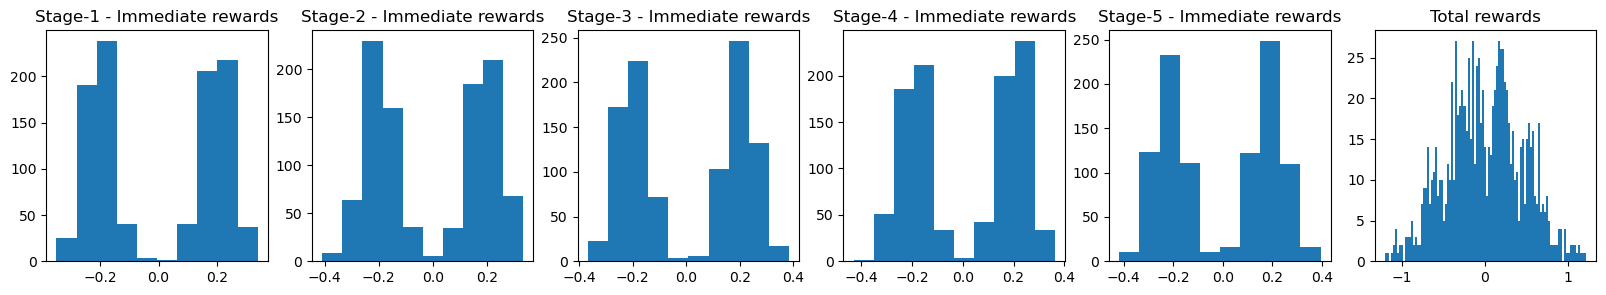

In [3]:
''' Visualize the stage-wise rewards
From the results, it can seen the first and third stage is the important stage,
having a larger scale of rewards. The total rewards have three modalitilies
1. both important stage matched
2. Either matched
3. neither matched
'''
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, T+1, figsize = (4*T, 3))
for t in range(T):
    axes[t].hist(utils.r[:,t])
    axes[t].set_title(f"Stage-{t+1} - Immediate rewards")
axes[-1].hist(utils.R, bins=100)
axes[-1].set_title("Total rewards")
plt.show()

## 3. Run proposed method

In [4]:
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import NN
reload(NN)
NN.reload(utils)

### 3.1 SAL

In [5]:
f_class = nn.Linear if homo else NN.TLinear
SAL = NN.trainNN(NN.DTRModel, V, [1], NN.SALoss, pi=None, sw=None, Rest=utils.R.mean(), theta=1,
    lr=5e-3, epochs=800, weight_decay=1e-8, T_max=2000, small=1e-10, f_class=f_class,
    verbose = True, verboseFunc=NN.DTRVerbose, display_intvl=200, seed=48, device='cpu')
res = NN.DTREval2(SAL, seed=seed)
print("SAL Complete\nTrain-{}\nTest-{}\n".format(res['train'], res['test']))    

Epoch 0 (lr:    0.005000):  Loss: -170.466 (O-Acc: 69.17%, Imp-Acc: nan%, K-acc: 98.50% VF: 0.384)	Val-Loss: -22.221 (O-Acc: 66.50%, Imp-Acc: nan%, VF: 0.361)
Epoch 200 (lr:    0.004878):  Loss: -195.571 (O-Acc: 80.35%, Imp-Acc: nan%, K-acc: 99.88% VF: 0.607)	Val-Loss: -23.110 (O-Acc: 79.50%, Imp-Acc: nan%, VF: 0.621)
Epoch 400 (lr:    0.004523):  Loss: -201.237 (O-Acc: 80.97%, Imp-Acc: nan%, K-acc: 99.75% VF: 0.620)	Val-Loss: -23.911 (O-Acc: 79.50%, Imp-Acc: nan%, VF: 0.621)
Epoch 600 (lr:    0.003969):  Loss: -203.935 (O-Acc: 81.55%, Imp-Acc: nan%, K-acc: 99.88% VF: 0.631)	Val-Loss: -24.248 (O-Acc: 80.50%, Imp-Acc: nan%, VF: 0.641)
Validation Loss:  -24.140
SAL Complete
Train-{'Acc': 79.425, 'Imp-Acc': nan, 'VF': 0.585, 'VF-obs': 0.006, 'VF-optim': 0.996}
Test-{'Acc': 80.0, 'Imp-Acc': nan, 'VF': 0.585, 'VF-obs': -0.006, 'VF-optim': 0.983}



### 3.2. SWL

In [6]:
# Learn the stage weights
weightNN = NN.trainNN(NN.WeightNNModel, V, [8, 1], NN.WeightLoss, theta=0,
                lr=1e-2, epochs=1200, weight_decay=1e-5, T_max=800, small=1e-8, f_class=nn.Linear,
                verbose = True, verboseFunc=NN.WeightVerbose, display_intvl=200, seed=48)
sw_pred = weightNN.getWeights()
si_pred = sw_pred.argsort()[0]
overlap_num = len(set(si_pred[-utils.num_important_stages:]).intersection(set(utils.si_arr)))
# Check whether the trained weights can reflect the true underlying true important stages
print(f"WeightNN Complete - Overlapp:  {overlap_num} out of {IS_num} important stages")        

Epoch 0 (lr:    0.010000, 0/0):  MSE: 1.936 (Val: 1.818)	IS: [0 2 4 1 3]	
[[0.19521977 0.20318703 0.19521993 0.20318703 0.20318627]]
Epoch 200 (lr:    0.008536, 0/0):  MSE: 0.129 (Val: 0.148)	IS: [0 2 3 1 4]	
[[0.14070216 0.20923263 0.15441431 0.18143255 0.3142184 ]]
Epoch 400 (lr:    0.005000, 0/0):  MSE: 0.122 (Val: 0.178)	IS: [0 2 3 1 4]	
[[0.12162028 0.20425855 0.17035784 0.19710356 0.30665988]]
Epoch 600 (lr:    0.001464, 0/0):  MSE: 0.127 (Val: 0.170)	IS: [0 2 3 1 4]	
[[0.11600672 0.20781589 0.16661674 0.2029289  0.3066318 ]]
Epoch 800 (lr:    0.000000, 0/0):  MSE: 0.127 (Val: 0.198)	IS: [0 2 3 1 4]	
[[0.11473492 0.20935166 0.17093353 0.2024265  0.30255336]]
Epoch 1000 (lr:    0.001464, 0/0):  MSE: 0.123 (Val: 0.192)	IS: [0 2 1 3 4]	
[[0.1150247  0.2022071  0.17454538 0.20529853 0.3029243 ]]
Validation Loss:  0.176
WeightNN Complete - Overlapp:  0 out of 0 important stages


In [7]:
SWL = NN.trainNN(NN.DTRModel, V, [1], NN.SWLoss, pi=None, sw=torch.tensor(sw_pred*T), Rest=utils.R.mean(), theta=1,
    lr=5e-3, epochs=800, weight_decay=1e-8, T_max=2000, small=1e-10, f_class=f_class,
    verbose = True, verboseFunc=NN.DTRVerbose, display_intvl=200, seed=48, device='cpu')
res = NN.DTREval2(SWL, seed=seed) 
print("SWL Complete\n{}\n{}\n".format(res['train'], res['test']))

Epoch 0 (lr:    0.005000):  Loss: -849.253 (O-Acc: 69.17%, Imp-Acc: nan%, K-acc: 98.50% VF: 0.384)	Val-Loss: -110.577 (O-Acc: 66.50%, Imp-Acc: nan%, VF: 0.361)
Epoch 200 (lr:    0.004878):  Loss: -978.996 (O-Acc: 80.35%, Imp-Acc: nan%, K-acc: 99.88% VF: 0.607)	Val-Loss: -114.920 (O-Acc: 79.50%, Imp-Acc: nan%, VF: 0.621)
Epoch 400 (lr:    0.004523):  Loss: -1008.571 (O-Acc: 80.97%, Imp-Acc: nan%, K-acc: 99.75% VF: 0.620)	Val-Loss: -118.946 (O-Acc: 79.50%, Imp-Acc: nan%, VF: 0.621)
Epoch 600 (lr:    0.003969):  Loss: -1022.869 (O-Acc: 81.55%, Imp-Acc: nan%, K-acc: 99.88% VF: 0.631)	Val-Loss: -121.631 (O-Acc: 80.50%, Imp-Acc: nan%, VF: 0.641)
Validation Loss:  -121.932
SWL Complete
{'Acc': 79.425, 'Imp-Acc': nan, 'VF': 0.585, 'VF-obs': 0.006, 'VF-optim': 0.996}
{'Acc': 80.0, 'Imp-Acc': nan, 'VF': 0.585, 'VF-obs': -0.006, 'VF-optim': 0.983}



## 4. Run competing methods

In [8]:
from IPython import get_ipython
kernel = get_ipython()
kernel.run_line_magic('load_ext', 'rpy2.ipython')

import CompetingMethod
reload(CompetingMethod)
CompetingMethod.set_kernel(kernel) # need kernel to run R in the background

CompetingMethod.set_utils(utils)
CompetingMethod.update_global_variable()

R[write to console]: Loading required package: modelObj



### 4.1 Q-learning

In [9]:
res = CompetingMethod.QL_unshared(seed=seed)
print("Q-learning Complete\nTrain-{}\nTest-{}\n".format(res['train'],res['test']))

Q-learning Complete
Train-{'Acc': 58.4, 'Imp-Acc': nan, 'VF': 0.167, 'VF-obs': 0.006, 'VF-optim': 0.996}
Test-{'Acc': 58.5, 'Imp-Acc': nan, 'VF': 0.156, 'VF-obs': -0.006, 'VF-optim': 0.983}



### 4.2 C-learning
#### Parametric

In [10]:
res = CompetingMethod.CLearning(seed=seed, nonParam='FALSE')
print("C-learning Complete\nTrain-{}\nTest-{}\n".format(res['train'],res['test']))

R[write to console]: ##  rgenoud (Version 5.9-0.10, Build Date: 2023-12-13)
##  See http://sekhon.berkeley.edu/rgenoud for additional documentation.
##  Please cite software as:
##   Walter Mebane, Jr. and Jasjeet S. Sekhon. 2011.
##   ``Genetic Optimization Using Derivatives: The rgenoud package for R.''
##   Journal of Statistical Software, 42(11): 1-26. 
##


R[write to console]: randomForest 4.7-1.2

R[write to console]: Type rfNews() to see new features/changes/bug fixes.



C-learning Complete
Train-{'Acc': 74.275, 'Imp-Acc': nan, 'VF': 0.483, 'VF-obs': 0.006, 'VF-optim': 0.996}
Test-{'Acc': 73.625, 'Imp-Acc': nan, 'VF': 0.455, 'VF-obs': -0.006, 'VF-optim': 0.983}



#### Non-parametric

In [11]:
res = CompetingMethod.CLearning(seed=seed, nonParam='TRUE')
print("C-learning Complete\nTrain-{}\nTest-{}\n".format(res['train'],res['test']))

C-learning Complete
Train-{'Acc': 71.45, 'Imp-Acc': nan, 'VF': 0.428, 'VF-obs': 0.006, 'VF-optim': 0.996}
Test-{'Acc': 69.875, 'Imp-Acc': nan, 'VF': 0.382, 'VF-obs': -0.006, 'VF-optim': 0.983}



### 4.3 BOWL / SOWL
Backward/simultaneous outcome weighted learning

In [12]:
res = CompetingMethod.BOWL(seed=seed)
print("BOWL Complete\nTrain-{}\nTest-{}\n".format(res['train'],res['test']))

res = CompetingMethod.SOWL(seed=seed)
print("SOWL Complete\nTrain-{}\nTest-{}\n".format(res['train'],res['test']))

BOWL Complete
Train-{'Acc': 73.425, 'Imp-Acc': nan, 'VF': 0.466, 'VF-obs': 0.006, 'VF-optim': 0.996}
Test-{'Acc': 70.5, 'Imp-Acc': nan, 'VF': 0.392, 'VF-obs': -0.006, 'VF-optim': 0.983}

SOWL Complete
Train-{'Acc': 49.3, 'Imp-Acc': nan, 'VF': -0.014, 'VF-obs': 0.006, 'VF-optim': 0.996}
Test-{'Acc': 48.25, 'Imp-Acc': nan, 'VF': -0.048, 'VF-obs': -0.006, 'VF-optim': 0.983}



### 4.4 RWL (residual weighted learning)

In [13]:
res = CompetingMethod.RWL(seed=seed)
print("RWL Complete\nTrain-{}\nTest-{}\n".format(res['train'],res['test']))

RWL Complete
Train-{'Acc': 71.2, 'Imp-Acc': nan, 'VF': 0.42, 'VF-obs': 0.006, 'VF-optim': 0.996}
Test-{'Acc': 71.875, 'Imp-Acc': nan, 'VF': 0.42, 'VF-obs': -0.006, 'VF-optim': 0.983}



### 4.5 AIPWE (augmented IPWE - robust esitmators)

In [14]:
res = CompetingMethod.AIPWClass(seed=seed)
print("AIPW Complete\nTrain-{}\nTest-{}\n".format(res['train'],res['test']))

AIPW Complete
Train-{'Acc': 60.975, 'Imp-Acc': nan, 'VF': 0.219, 'VF-obs': 0.006, 'VF-optim': 0.996}
Test-{'Acc': 59.25, 'Imp-Acc': nan, 'VF': 0.171, 'VF-obs': -0.006, 'VF-optim': 0.983}



### 4.6 DQN (Deep Q-Network - infinite horizon)


In [15]:
res = CompetingMethod.train_DQN(seed=seed)
print("DQN Complete\nTrain-{}\nTest-{}\n".format(res['train'],res['test']))

train done
DQN Complete
Train-{'Acc': 67.2, 'Imp-Acc': nan, 'VF': 0.342, 'VF-obs': 0.006, 'VF-optim': 0.996}
Test-{'Acc': 64.875, 'Imp-Acc': nan, 'VF': 0.283, 'VF-obs': -0.006, 'VF-optim': 0.983}

